## Линейная регрессия: переобучение и регуляризация

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Будем работать с датасетом **"bikes_rent.csv"**, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок.

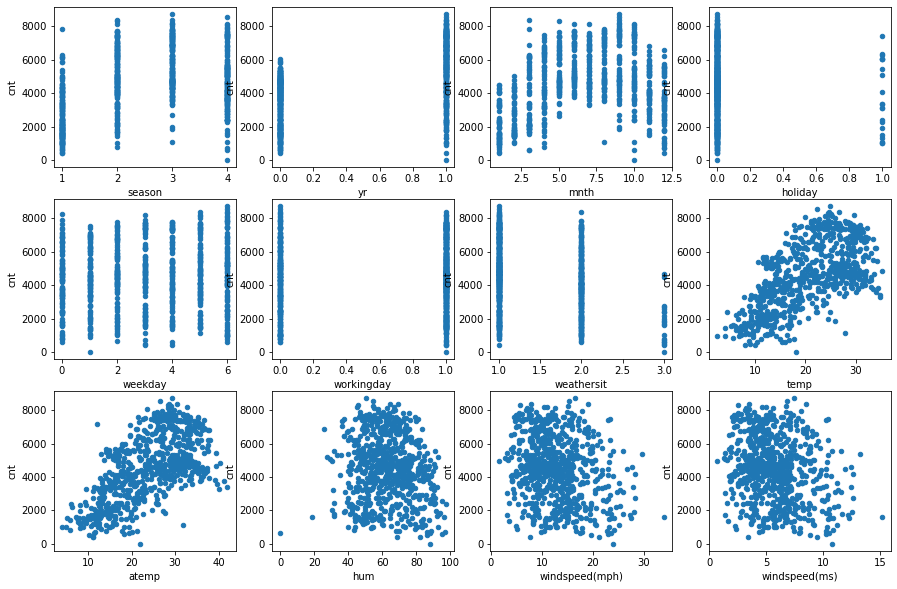

In [3]:
#Выведем на графиках, как целевой признак зависит от остальных
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Видим квадратичную зависимость числа прокатов от месяца. А также линейную зависимость целевой переменной от скорости ветра

Более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Посчитаем корреляции всех признаков с последним с помощью метода corrwith:
df[df.columns[:-1]].corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Посчитаем корреляции между вещественными признаками.

In [5]:
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Посмотрим средние признаков, чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

print(linear_regressor.coef_)
print(list(zip(df.columns, linear_regressor.coef_)))

[ 5.70867701e+02  1.02196988e+03 -1.41302332e+02 -8.67577457e+01
  1.37225199e+02  5.63942501e+01 -3.30233706e+02  3.67484073e+02
  5.85545038e+02 -1.45605187e+02  1.24566467e+13 -1.24566467e+13]
[('season', 570.8677013747067), ('yr', 1021.9698782796611), ('mnth', -141.3023317102269), ('holiday', -86.75774568460926), ('weekday', 137.2251988557663), ('workingday', 56.39425012546628), ('weathersit', -330.23370554415067), ('temp', 367.48407255394744), ('atemp', 585.5450378364735), ('hum', -145.60518734458537), ('windspeed(mph)', 12456646672315.316), ('windspeed(ms)', -12456646672513.77)]


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют проблемой мультиколлинеарности, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

Обучим регрессоры Ridge и Lasso

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
lasso = Lasso()
lasso.fit(X, y)
print(list(zip(df.columns, lasso.coef_)))

[('season', 560.2416160308869), ('yr', 1019.4634940657196), ('mnth', -128.73062703678752), ('holiday', -86.15278133371116), ('weekday', 137.34789390496314), ('workingday', 55.212370641356685), ('weathersit', -332.3698569623484), ('temp', 376.3632362096995), ('atemp', 576.5307935045503), ('hum', -144.1291550034858), ('windspeed(mph)', -197.13968940248557), ('windspeed(ms)', -2.8050167469807684e-08)]


In [13]:
ridge = Ridge()
ridge.fit(X, y)
print(list(zip(df.columns, ridge.coef_)))

[('season', 563.0645722520097), ('yr', 1018.9483787875305), ('mnth', -131.8733202824732), ('holiday', -86.74609799709164), ('weekday', 138.00511117871943), ('workingday', 55.90311037506477), ('weathersit', -332.34978849907463), ('temp', 386.45788919195707), ('atemp', 566.3470470600196), ('hum', -145.07132729867033), ('windspeed(mph)', -99.25944108204882), ('windspeed(ms)', -99.25944115408527)]


### Проблема вторая: неинформативные признаки

Пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ 

In [14]:
alphas = np.arange(1, 500, 50)
# матрица весов размера (число регрессоров) x (число признаков)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for idx, a in enumerate(alphas):
    lasso_regressor = Lasso(alpha=a)
    lasso_regressor.fit(X, y)
    coefs_lasso[idx] = lasso_regressor.coef_

    ridge_regressor = Ridge(alpha=a)
    ridge_regressor.fit(X, y)
    coefs_ridge[idx] = ridge_regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

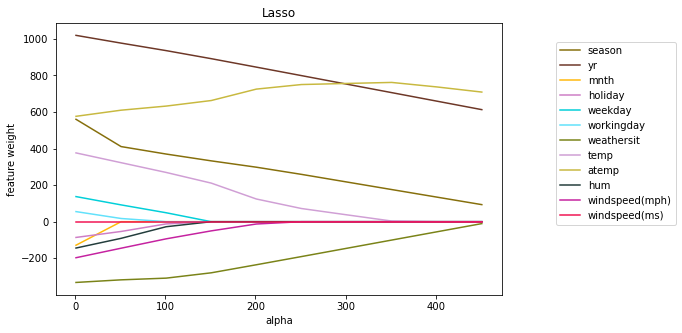

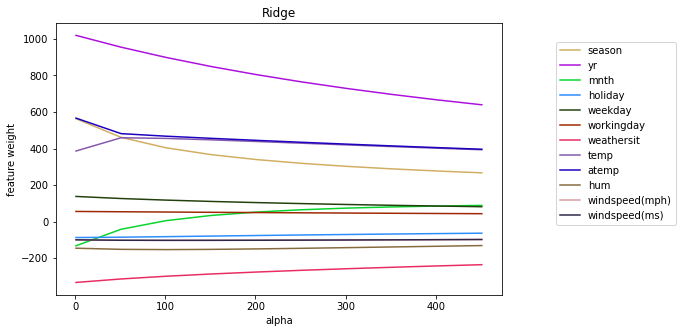

In [29]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Видим, что Lasso лучше подойдходит для отбора неинформативных признаков.

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

In [15]:
from sklearn.linear_model import LassoCV

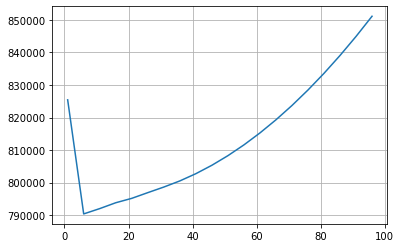

Выбранное alpha: 6

season: 532.018983
yr: 1015.060223
mnth: -100.039526
holiday: -83.293960
weekday: 132.504465
workingday: 51.557086
weathersit: -330.559857
temp: 370.679855
atemp: 581.396931
hum: -140.007406
windspeed(mph): -191.771408
windspeed(ms): -0.000000


In [16]:
# Обучим регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график _усредненного_ по строкам MSE в зависимости от alpha. 
alphas = np.arange(1, 100, 5)
lasso_cv_regressor = LassoCV(alphas=alphas, cv=3)
lasso_cv_regressor.fit(X, y)
plt.plot(lasso_cv_regressor.alphas_, lasso_cv_regressor.mse_path_.mean(axis=1)) # Построение графика
plt.grid(True) 
plt.show() 
print ('Выбранное alpha: %d\n' % lasso_cv_regressor.alpha_)
for feature, coef in zip(df.columns, lasso_cv_regressor.coef_):
    print ('%s: %f' % (feature, coef))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

alpha=41, min(MSE)=843336.1814988225
alpha=6, min(MSE)=772598.4956277699
alpha=1, min(MSE)=745668.6059608028


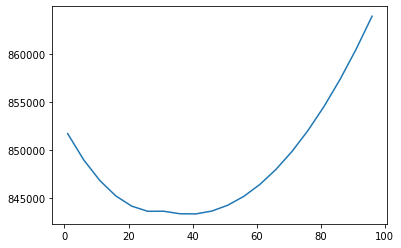

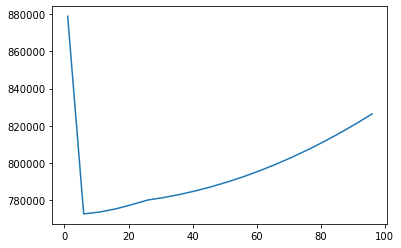

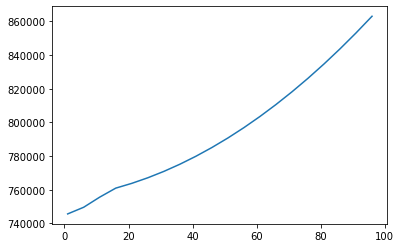

In [17]:
# Выведем значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# Визуализируем столбцы .mse_path_
import operator
for idx in range(lasso_cv_regressor.mse_path_.shape[1]):
    fig, axes = plt.subplots()
    col = lasso_cv_regressor.mse_path_[:, idx]
    min_index, min_value = min(enumerate(col), key=operator.itemgetter(1))
    print(f"alpha={lasso_cv_regressor.alphas_[min_index]}, min(MSE)={min_value}")
    axes.plot(alphas, col[::-1])

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Признаки с наибольшими положительными коэфициентами: season, yr, atemp, temp
Логично предположить, что чем больше значение этих признаков, тем больше людей захотят взять велосипеды
признаки с наибольшими по модулю отрицательными коэффициентами: weathersit, hum, windspeed(mph)
Чем больше величина этих признаков, тем меньше людей захотят взять велосипеды